In [107]:
import os
import re
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

# General device handling: Check for CUDA/GPU, else fallback to CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Setup Variables

In [4]:
PATCH_SIZE = 256

classes = {
    0: 'Control',
    1: 'Depolymerised',
}

# Training

## Building Model

In [5]:
#Works on input of shape (batch, channels, [Image Shape])
class TileChannels(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def forward(self, x):
        shape = x.shape
        tiled_x = x.repeat(1, self.n, *([1] * (len(shape) - 2)))
        
        return tiled_x


In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        if stride not in [1,2]:
            raise ValueError(f"Stride for a ResNet Block must be 1 or 2, not {stride}")
        self.downsample = (stride == 2)
        
        if self.downsample:
            self.downsample_pool = nn.MaxPool2d(kernel_size=2)
            self.downsample_tile_channels = TileChannels(n=2)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=self.out_channels,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               padding_mode='circular')
        self.bn1 = nn.BatchNorm2d(num_features=self.out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=self.out_channels,
                               out_channels=self.out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               padding_mode='circular')
        self.bn2 = nn.BatchNorm2d(num_features=self.out_channels)
        self.relu2 = nn.ReLU() 
        
        self.relu3 = nn.ReLU() 

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        #Fix skip connection to match shape of transformed x
        if self.downsample:
            #Fix image size
            identity = self.downsample_pool(identity)
            #Fix number of channels
            identity = self.downsample_tile_channels(identity)
            
        x = x + identity
        
        x = self.relu3(x)
        
        return x


In [7]:
# Can only process input image size multiple of (32, 32)
class ResNet(nn.Module):
    def __init__(self, layers, in_channels=1, num_classes=2):
        if len(layers) != 4:
            raise ValueError(f"ResNet only supports 4 layers, not the provided layer list {layers} of length {len(layers)}")
            
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               padding_mode='circular')
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.layer1 = self._make_layer(in_channels=64, 
                                       out_channels=64, 
                                       num_blocks=layers[0],
                                       downsample=False)
        
        self.layer2 = self._make_layer(in_channels=64, 
                                       out_channels=128, 
                                       num_blocks=layers[1],
                                       downsample=True)
        
        self.layer3 = self._make_layer(in_channels=128, 
                                       out_channels=256, 
                                       num_blocks=layers[2],
                                       downsample=True)
        
        self.layer4 = self._make_layer(in_channels=256, 
                                       out_channels=512, 
                                       num_blocks=layers[3],
                                       downsample=True)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        
        self.lin = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_classes),
        )
        
    def _make_layer(self, in_channels, out_channels, num_blocks, downsample):
        layers = []
        
        for i in range(num_blocks):
            stride = 2 if (i == 0 and downsample) else 1
            local_in_channels = in_channels if (i==0) else out_channels
            local_out_channels = out_channels
            
            layer = ResNetBlock(in_channels=local_in_channels, out_channels=local_out_channels, stride=stride)
            
            layers.append(layer)
        
        return nn.Sequential(*layers)

    def forward(self, x):
        #shape of x = (Batch, Channels, Height, Width)
        if len(x.shape) != 4:
            raise ValueError(f"ResNet only processes input of shape (batch, channels, height, width), not {tuple(x.shape)}")
        B, C, H, W = x.shape
        if W % 32 != 0 or H % 32 != 0:
            raise ValueError(f"ResNet can only process images whose dimensions are divisible by 32, not {W} x {H}. \n Full Input shape: {tuple(x.shape)}")
        
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = self.lin(x)
        
        return x
        

## Training and Testing Functions

In [7]:
def train(model, train_loader, criterion, optimizer, epoch, device):
    model.to(device)
    model.train()
    running_loss = 0.0

    # Get the first parameter that requires gradients
    param_name_to_monitor = next(name for name, param in model.named_parameters() if param.requires_grad)
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Debugging: Print the gradient of the specific parameter before optimizer step
        # param = dict(model.named_parameters())[param_name_to_monitor]
        # if param.grad is not None:
        #    print(f'{param_name_to_monitor}.grad: {param.grad.norm()}')
    
        optimizer.step()

        # Debugging: Print the norm of the specific parameter to check if it is changing
        # print(f'{param_name_to_monitor}: {param.norm()}')

        running_loss += loss.item()

#     print(f"Epoch {epoch} - Training loss: {running_loss / len(train_loader)}")

# Usage example (assuming your model, criterion, optimizer, train_loader, and device are defined):
# train(model, train_loader, criterion, optimizer, epoch=1, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [8]:
#Run each epoch
def test(model, test_loader, criterion, verbose=False):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.max(1)[1]).sum().item()
            
#             if batch_idx == 0:
#                 print(outputs)
#                 print(targets)
            
    accuracy = 100. * correct / total
    
    if verbose:
        print(f"Test loss: {test_loss}")
        print(f"Accuracy: {accuracy}")
        
    return {
        'Test Loss': test_loss,
        'Accuracy': accuracy,
    }

## Custom Dataset

In [9]:
# Expected directory structure:
# Base dir
# - Control
# -- image-{a}.png
# ...
# -- image-{b}.png
# - Depoly
# -- image-{a}.png
# ...
# -- image-{b}.png

# We assign (1,0) = Control and (0,1) = Depoly for labels

class ProcessedTubulatonDataset(Dataset):
    train_test_split=0.8
    
    def __init__(self, base_dir='/Users/karan/Microtubules/Data/Tubulaton-Processed', transform=None, for_training=True, **kwargs):
        super().__init__()
        
        self.base_dir = base_dir
        self.transform = transform
        
        filenames = os.listdir(os.path.join(self.base_dir, 'Control'))
        indexes = [int(re.search(r'image-(\d+)\.png', xs).group(1)) for xs in filenames]
        
        self.start_index = min(indexes)
        self.end_index = max(indexes)+1
        
        self.train_cutoff = int(self.start_index + ProcessedTubulatonDataset.train_test_split * (self.end_index - self.start_index))
        
        self.for_training = for_training
        
        if self.for_training:
            self.end_index = self.train_cutoff
        else:
            self.start_index = self.train_cutoff

    def __len__(self):
        return 2 * (self.end_index - self.start_index)

    def __getitem__(self, raw_idx):
        if raw_idx >= len(self) // 2:
            idx = raw_idx - (len(self)//2) + self.start_index
            label = np.array([0., 1.]).astype(np.float32)
            image_path = os.path.join(self.base_dir, f'Depoly/image-{idx}.png')
        else:
            idx = raw_idx + self.start_index
            label = np.array([1., 0.]).astype(np.float32)
            image_path = os.path.join(self.base_dir, f'Control/image-{idx}.png')

        image = Image.open(image_path)
        
        image = (np.array(image) / 255.).astype(np.float32)
        assert len(image.shape) == 2
        
        if self.transform:
            image = self.transform(image)

        return image, label

## Load Data

In [10]:
# Data transformations
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(PATCH_SIZE, pad_if_needed=True, padding_mode='symmetric'),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(PATCH_SIZE, pad_if_needed=True, padding_mode='symmetric'),
])

train_set = ProcessedTubulatonDataset(shuffle=True, for_training=True, transform=transform_train)
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=0)

test_set = ProcessedTubulatonDataset(shuffle=True, for_training=False, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=0)

## Train Model

In [91]:
# Initialize model, loss function, optimizer, and scheduler
layers = [2,2,2,2]
in_channels = 1
num_classes=2

model = ResNet(layers=layers, in_channels=in_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and testing loop
num_epochs = 30

with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        train(model, train_loader, criterion, optimizer, epoch, device)
        pbar_ordered_dict = test(model, test_loader, criterion)
        scheduler.step()
        
        pbar.update(1)
        pbar.set_postfix(ordered_dict=pbar_ordered_dict)
        
#Save the model to file
torch.save(model.state_dict(), f'/Users/karan/Microtubules/Models/classifier-{layers}-{in_channels}-{num_classes}.pth')

# Inference (Works on a PNG)

## Load weights 

In [8]:
layers = [2,2,2,2]
in_channels = 1
num_classes=2

model = ResNet(layers=layers, in_channels=in_channels, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(f'/Users/karan/Microtubules/Models/classifier-{layers}-{in_channels}-{num_classes}.pth'))
model.eval()  # Set the model to evaluation mode

print("Loaded trained ResNet model")

Loaded trained ResNet model


## Run Inference

In [81]:
def get_image_patches(image, patch_size):
    # batch, channels, height, width
    b, c, h, w = image.shape
    patch_h, patch_w = patch_size
    
    # Apply circular padding
    pad_h = (patch_h - (h % patch_h)) % patch_h
    pad_w = (patch_w - (w % patch_w)) % patch_w

    padded_image = None
    if pad_h > 0 or pad_w > 0:
        padded_image = F.pad(image, (0, pad_w, 0, pad_h), mode='circular')
    else:
        padded_image = image

    # Unfold to extract patches
    patches = padded_image.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
    
    # Reshape tensor
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(-1, c, patch_h, patch_w)
    
    return patches

In [130]:
def display_image_classification(image_path : str,
                                 model : ResNet, 
                                 verbose : bool = False) -> None:
    # Load image into appropriate tensor shape
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    # Add batch dimension
    image_tensor = transform(image).unsqueeze(0) 
    _, _, height, width = image_tensor.shape

    #Get patches
    patches = get_image_patches(image_tensor, (PATCH_SIZE, PATCH_SIZE)).to(device)
    height_in_patches = (height + PATCH_SIZE - 1) // PATCH_SIZE
    width_in_patches = (width + PATCH_SIZE - 1) // PATCH_SIZE

    # Run inference on each patch and collect logits
    with torch.no_grad():
        logits = model(patches)
    probabilities = F.softmax(logits, dim=1)[:, 0].to('cpu').numpy()


    # Draw image with probabilities overlaid
    cax = plt.imshow(image, cmap='gray')
    plt.axis('off')
    for i in range(height_in_patches):
        for j in range(width_in_patches):
            index = 4*i + j

            #Probability patch is polymerised (control)
            probability = probabilities[index]

            color = plt.cm.inferno(probability)  
            color_with_alpha = color[:3] + (0.5,)
            square = plt.Rectangle((j * PATCH_SIZE, i * PATCH_SIZE), PATCH_SIZE, PATCH_SIZE, 
                                   facecolor=color_with_alpha, edgecolor='none')

            plt.gca().add_patch(square)
    plt.show()

    # Draw probabilities on their own
    cax = plt.imshow(image, cmap='gray')
    plt.axis('off')
    for i in range(height_in_patches):
        for j in range(width_in_patches):
            index = 4*i + j

            #Probability patch is polymerised (control)
            probability = probabilities[index]

            color = plt.cm.inferno(probability)  
            color_with_alpha = color[:3] + (1.,)
            square = plt.Rectangle((j * PATCH_SIZE, i * PATCH_SIZE), PATCH_SIZE, PATCH_SIZE, 
                                   facecolor=color_with_alpha, edgecolor='none')

            plt.gca().add_patch(square)
    
    #Draw Colourbar
    fig, ax = plt.subplots(figsize=(6,1))

    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    ax.imshow(gradient, aspect='auto', cmap='inferno', extent=(0, 1, 0.49, 0.51))

    ax.axis('off')
    plt.show()

    #Draw histogram
    bins = np.histogram_bin_edges(probabilities, bins='auto')
    plt.hist(probabilities, bins=bins, edgecolor='black')
    plt.xlabel('Patch Polymerisation Probability')
    plt.ylabel('Frequency')
    plt.show()

    # TODO - an appropriate aggregation
    # aggregated_logits = logits.mean(dim=0)
    # _, predicted_class = torch.max(aggregated_logits, dim=0)


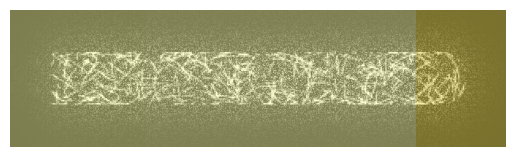

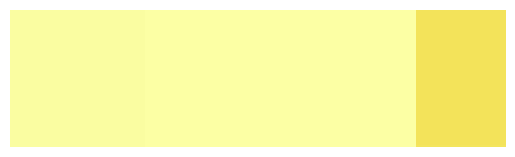

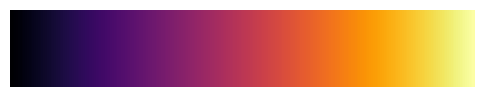

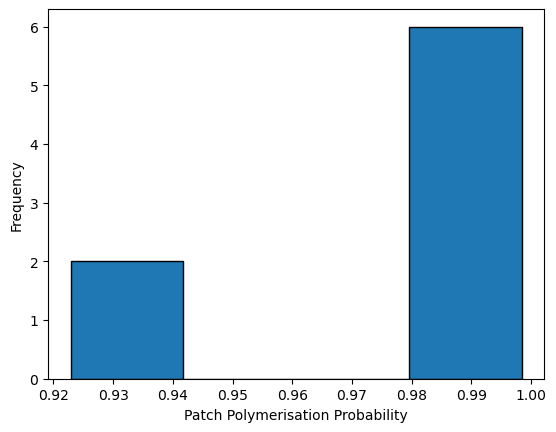

In [134]:
image_path = '/Users/karan/Microtubules/Data/Tubulaton-Processed/Control/image-65.png'
display_image_classification(image_path=image_path, 
                             model=model)


## Random Tests/Sandbox

### Drawing a rectangular patch onto an Image

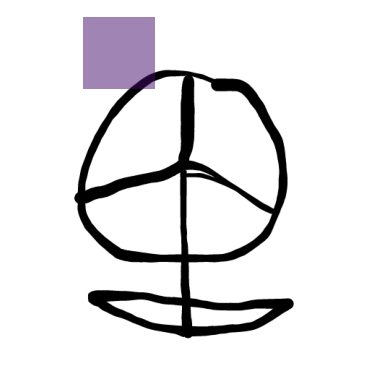

In [79]:
image_path = "/Users/karan/Microtubules/Drawing2.png"
image = Image.open(image_path).convert('RGB')
plt.imshow(image)

color = plt.cm.inferno(0.2)  
color_with_alpha = color[:3] + (0.5,)
square = plt.Rectangle((100, 10), 100, 100, facecolor=color_with_alpha, edgecolor='none')
plt.gca().add_patch(square)

plt.axis('off')
plt.show()

### Drawing a Color Bar

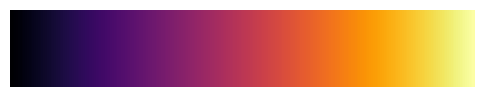

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an axis
fig, ax = plt.subplots()

# Define the gradient
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Display the gradient
ax.imshow(gradient, aspect='auto', cmap='inferno', extent=(0, 1, 0.49, 0.51))

# Set the limits and show the plot
ax.axis('off')
plt.show()